In [1]:
from aqua import Reader,catalogue, inspect_catalogue
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import diag_functions as fn
import warnings

warnings.filterwarnings("ignore", message="Slicing is producing a large chunk.")


FDB5 binary library not present on system, disabling FDB support.


In [2]:
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")
data = reader.retrieve()

data=data.rename({"nz1":"lev"})
data=data.rename({"ocpt":"thetao"})
data=data[["thetao","so"]]

yearly_data=data.resample(time="Y").mean()
yearly_data

<xarray.Dataset>
Dimensions:  (time: 5, lev: 69, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lev      (lev) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
  * time     (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2024-12-31
Data variables:
    thetao   (time, lev, lat, lon) float64 dask.array<chunksize=(1, 69, 180, 360), meta=np.ndarray>
    so       (time, lev, lat, lon) float64 dask.array<chunksize=(1, 69, 180, 360), meta=np.ndarray>

In [3]:

global_mean_anom=fn.std_anom_wrt_initial(yearly_data,-90,90,0,360)
atlantic_mean_anom=fn.std_anom_wrt_initial(yearly_data,-35,65,-80,30)
pacific_mean_anom=fn.std_anom_wrt_initial(yearly_data,-55,65,120,290)
indian_mean_anom=fn.std_anom_wrt_initial(yearly_data,-35,30,30,115)
arctic_mean_anom=fn.std_anom_wrt_initial(yearly_data,65,90,0,360)
southern_mean_anom=fn.std_anom_wrt_initial(yearly_data,-80,-55,-180,180)

/home/b/b382397/.conda/envs/aqua/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382397/.conda/envs/aqua/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382397/.conda/envs/aqua/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382397/.conda/envs/aqua/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


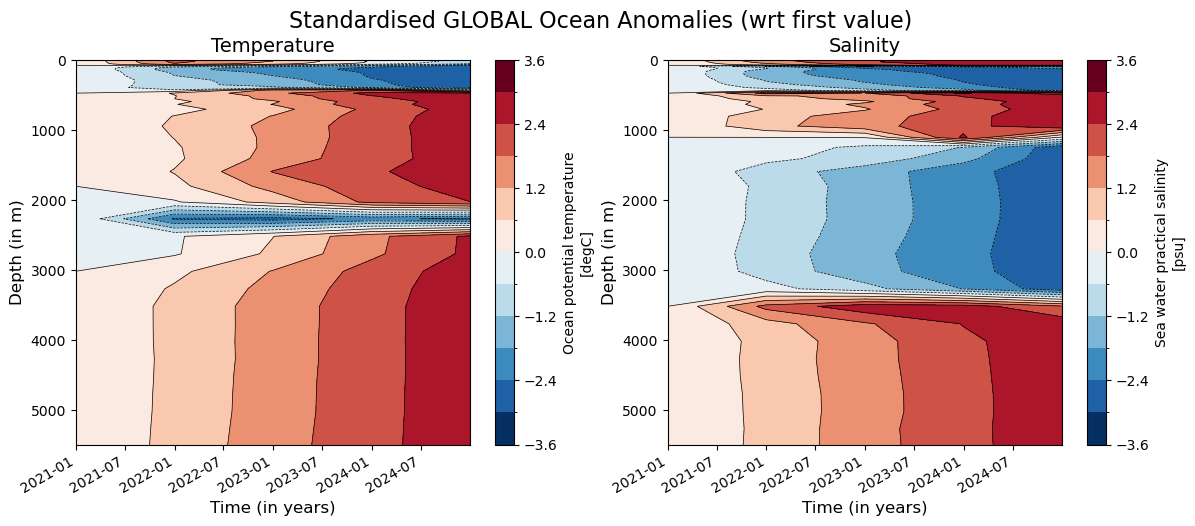

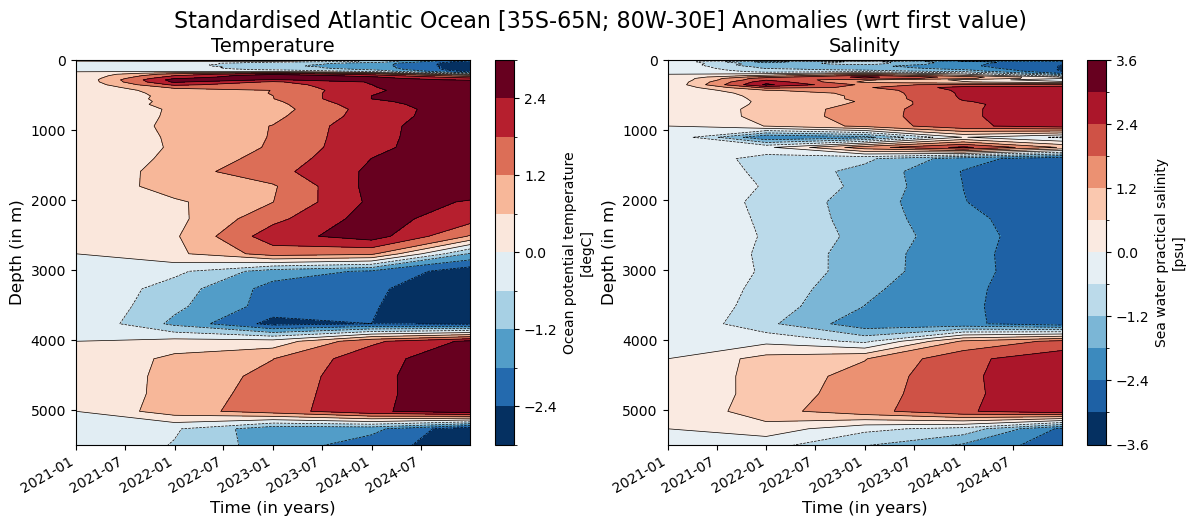

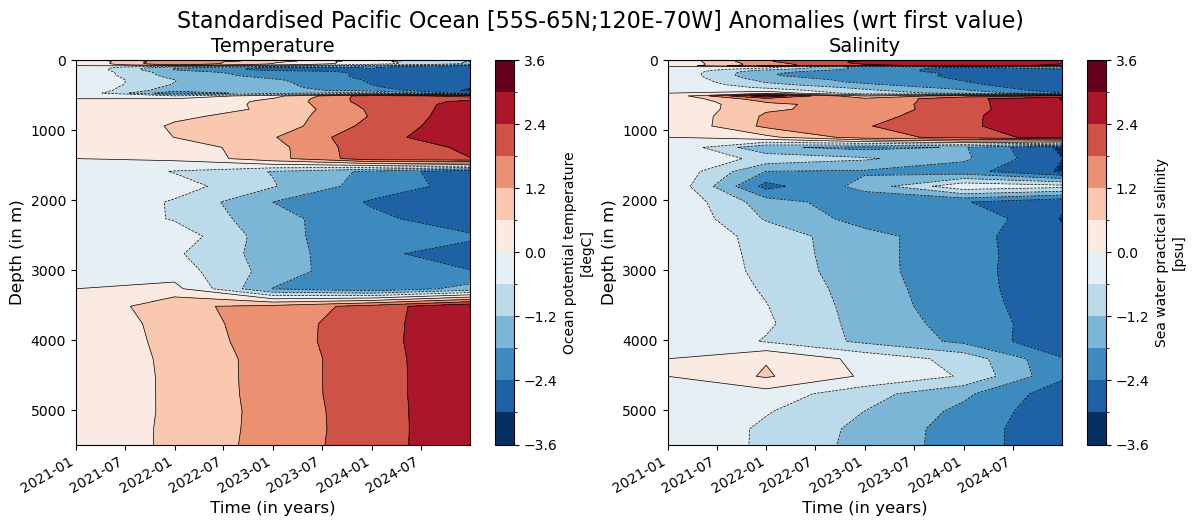

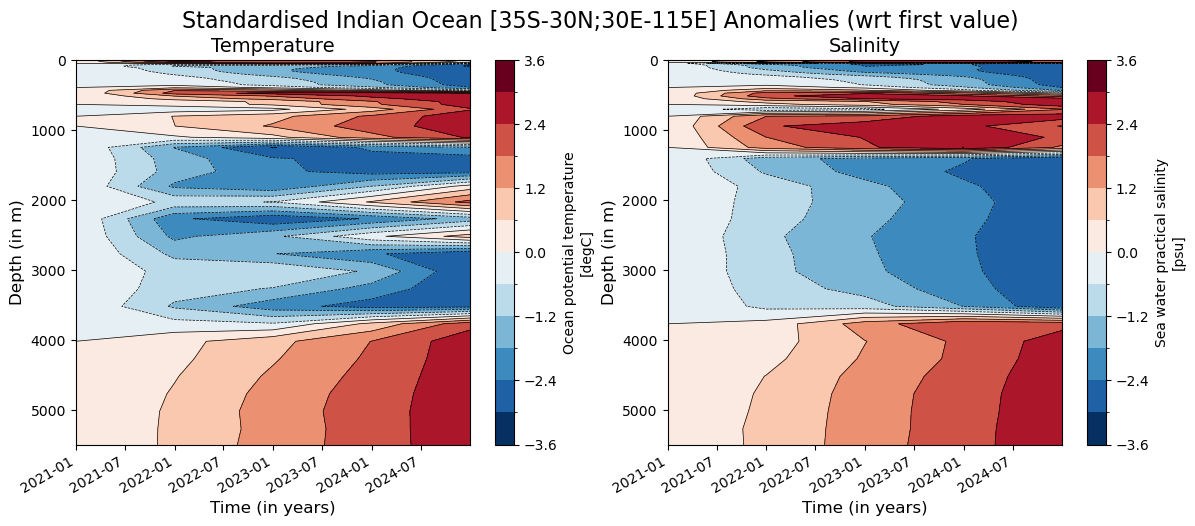

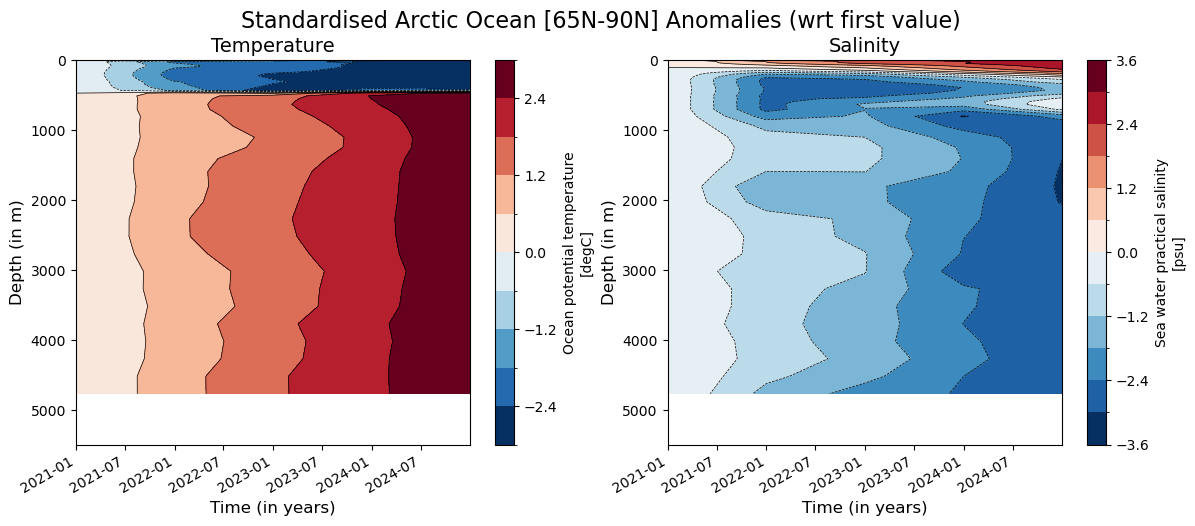

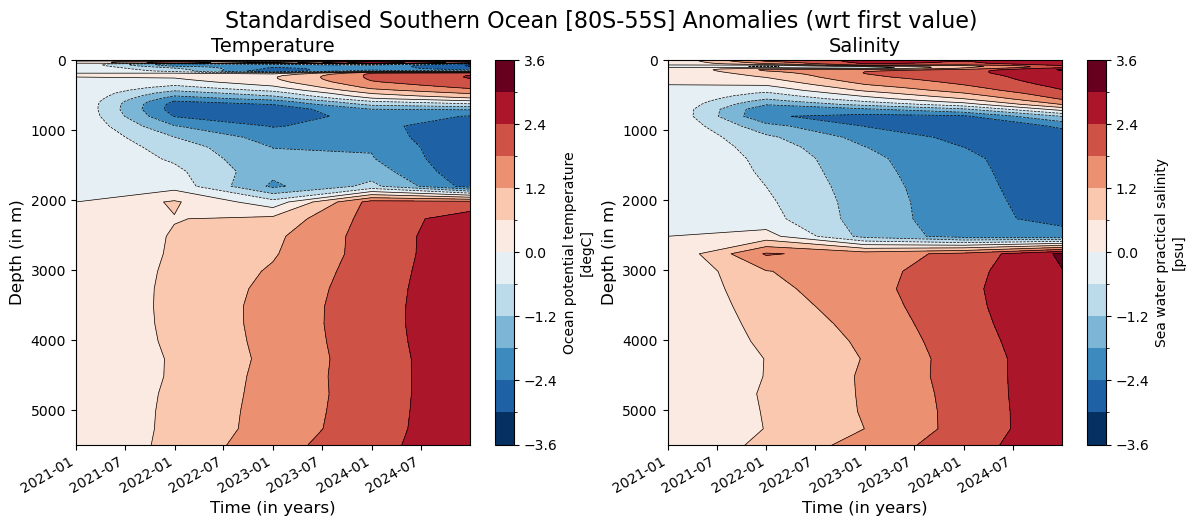

In [5]:
fn.thetao_so_anom_plot(global_mean_anom,"Standardised GLOBAL Ocean Anomalies (wrt first value)")
fn.thetao_so_anom_plot(atlantic_mean_anom,"Standardised Atlantic Ocean [35S-65N; 80W-30E] Anomalies (wrt first value)")
fn.thetao_so_anom_plot(pacific_mean_anom,"Standardised Pacific Ocean [55S-65N;120E-70W] Anomalies (wrt first value)")
fn.thetao_so_anom_plot(indian_mean_anom,"Standardised Indian Ocean [35S-30N;30E-115E] Anomalies (wrt first value)")
fn.thetao_so_anom_plot(arctic_mean_anom,"Standardised Arctic Ocean [65N-90N] Anomalies (wrt first value)")
fn.thetao_so_anom_plot(southern_mean_anom,"Standardised Southern Ocean [80S-55S] Anomalies (wrt first value)")

/home/b/b382397/.conda/envs/aqua/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


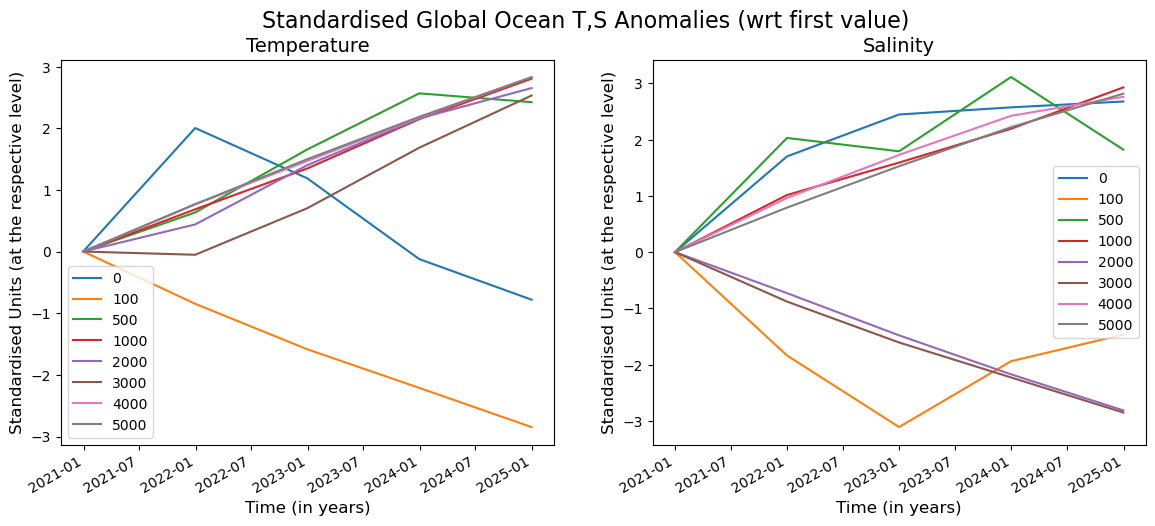

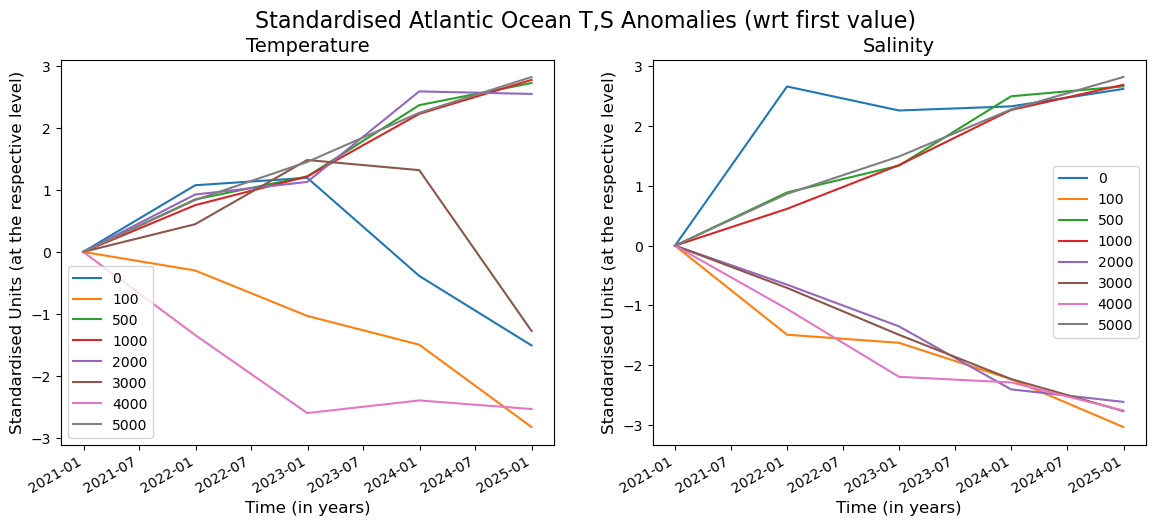

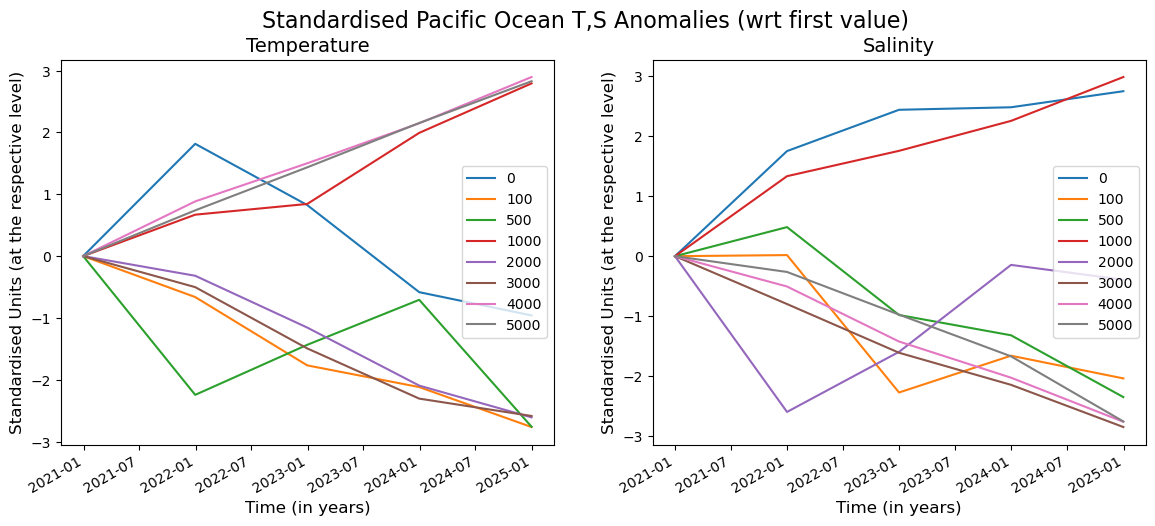

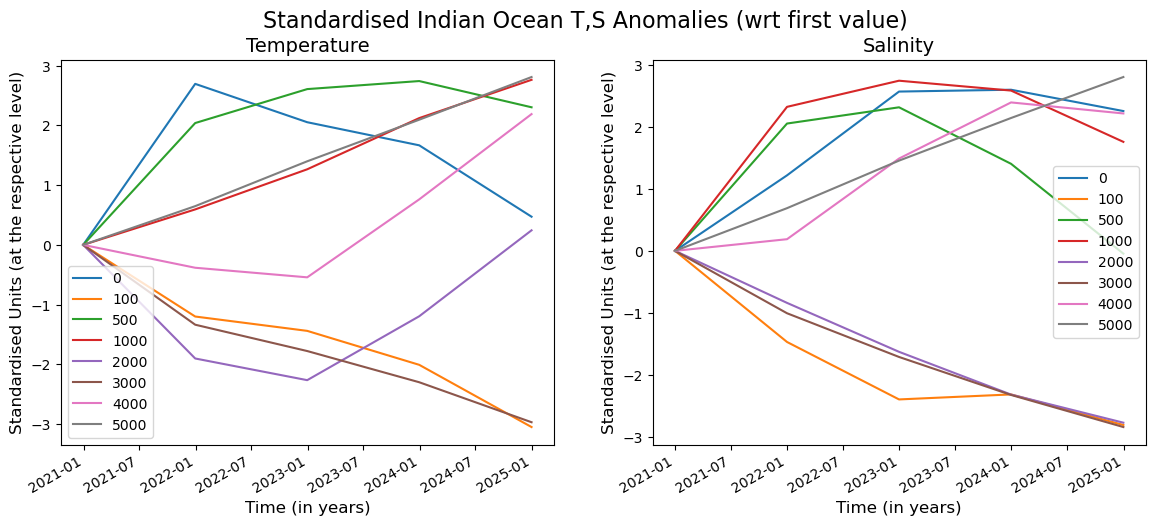

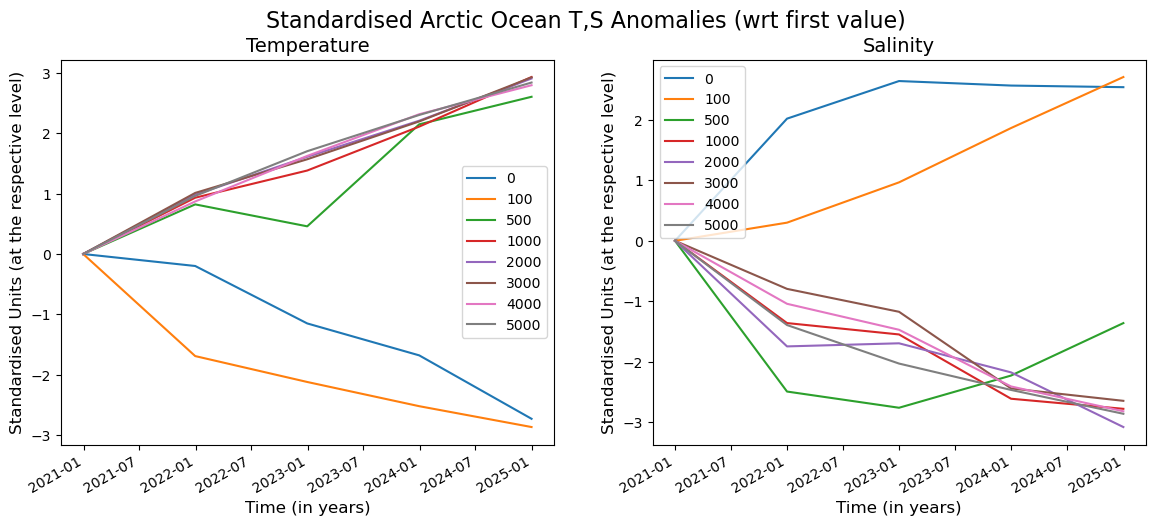

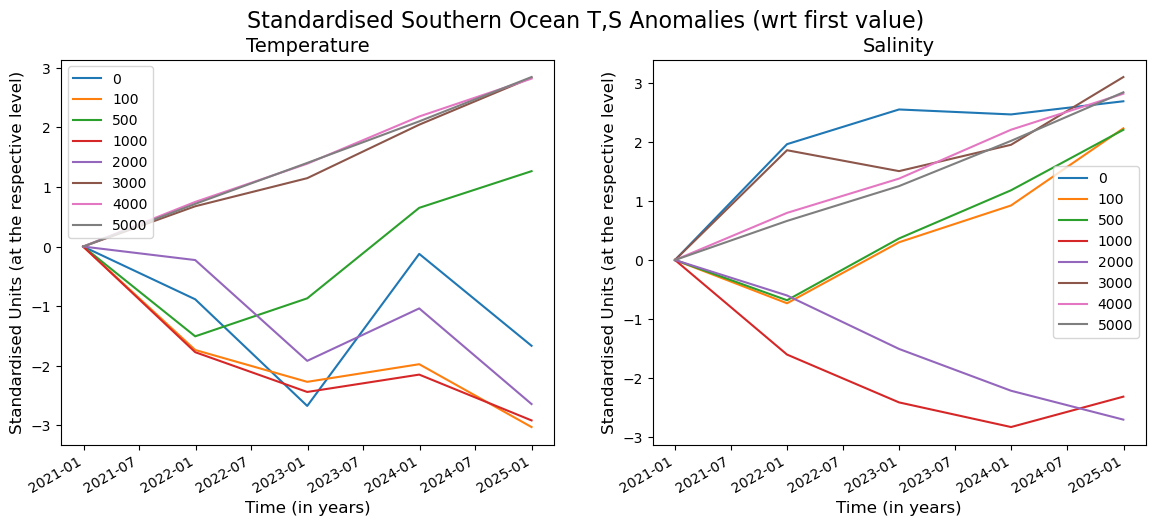

In [6]:
fn.time_series(global_mean_anom,'Standardised Global Ocean T,S Anomalies (wrt first value)')
fn.time_series(atlantic_mean_anom,'Standardised Atlantic Ocean T,S Anomalies (wrt first value)')
fn.time_series(pacific_mean_anom,'Standardised Pacific Ocean T,S Anomalies (wrt first value)')
fn.time_series(indian_mean_anom,'Standardised Indian Ocean T,S Anomalies (wrt first value)')
fn.time_series(arctic_mean_anom,'Standardised Arctic Ocean T,S Anomalies (wrt first value)')
fn.time_series(southern_mean_anom,'Standardised Southern Ocean T,S Anomalies (wrt first value)')